In [2]:
import numpy as np
from CT import *
import matplotlib.pyplot as plt

In [3]:
def run_quantum(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=True)
    # for ii in range(100):
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.half_system_entanglement_entropy()
    return O,SA

In [4]:
def run_quantum_anc(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=False,ancilla=True)
    # for ii in range(100):
    for _ in range(ct.L**2//2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
    O=ct.order_parameter()
    SA=ct.von_Neumann_entropy_pure([ct.L])
    return O,SA

In [5]:
def run_quantum_thermalization(inputs):
    L,p_ctrl,p_proj,idx=inputs
    ct=CT_quantum(L=L,x0=None,seed=idx,history=True)
    SA_list=[]
    for _ in range(2*ct.L**2):
        ct.random_control_2(p_ctrl=p_ctrl,p_proj=p_proj)
        SA=ct.half_system_entanglement_entropy()
        SA_list.append(SA)
    # O=ct.order_parameter()
    return np.array(SA_list)
    # return ct

In [6]:
def rescale(x,alpha):
    '''rescale the granularity near (a+b)/2, where a, b are boundary of the range x '''
    a,b=min(x),max(x)
    x1=(x-a)*2/(b-a)-1
    y1=np.sign(x1)*np.abs(x1)**alpha
    return (y1+1)*(b-a)/2+a

In [9]:
from ipyparallel import Client
client = Client()

In [12]:
dview = client[:]

In [13]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

## p_ctrol=1, sweep L

In [7]:
L_list=np.array([6,8,10,12,14,16])
# p_ctrl_list=np.linspace(.0,1,11)
# p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,1,0,idx) for L in L_list for idx in range(ensemble)]

## fix p_proj, sweep p_ctrol for different L

In [113]:
L_list=np.array([10,12,14,])
p_ctrl_list=np.linspace(.2,.8,11)
p_ctrl_list=rescale(p_ctrl_list, 2)
ensemble=2000
inputs=[(L,p_ctrl,0,idx) for L in L_list for p_ctrl in p_ctrl_list for idx in range(ensemble)]

## sweep p_proj, sweep p_ctrol for different L

In [14]:
L_list=np.array([10,12,14,])
p_ctrl_list=np.linspace(0.,1,21)
# p_ctrl_list=rescale(p_ctrl_list, 2)
p_proj_list=np.linspace(0,0.5,6)
ensemble=1000
inputs=[(L,p_ctrl,p_proj,idx) for L in L_list for p_ctrl in p_ctrl_list for p_proj in p_proj_list for idx in range(ensemble)]

## Everything fixed to check thermalization time

In [87]:
ensemble=10000
inputs=[(12,0.5,0,idx) for idx in range(ensemble)]

## parallel run

In [15]:
results = dview.map_async(run_quantum, inputs)
# results = dview.map_async(run_quantum_anc, inputs)
# results = dview.map_async(run_quantum_thermalization, inputs)

In [16]:
len(inputs)

378000

In [27]:
results.progress

378000

In [26]:
results.elapsed

1708.105242

## p_ctrol=1, sweep L

In [18]:
rs=np.array(list(results)).reshape((L_list.shape[0],ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

Text(0, 0.5, '$\\overline{\\langle O \\rangle}$')

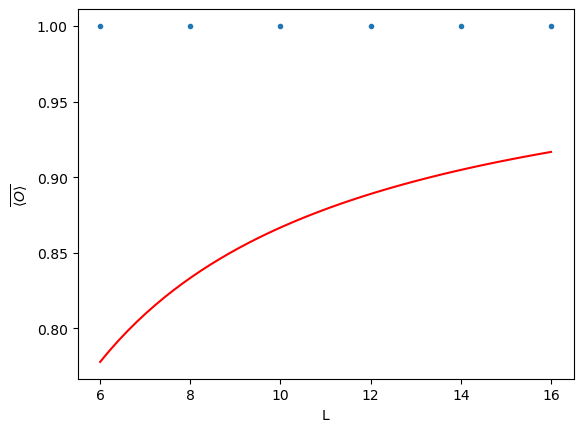

In [19]:
fig,ax=plt.subplots()
ax.plot(L_list,O_map.mean(axis=-1),'.')
L_list_cont=np.linspace(6,16)
ax.plot(L_list_cont,1-4/(3*(L_list_cont)),color='r',label='')
ax.set_xlabel('L')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')

## p_proj=0, sweep p_ctrol for different L

In [122]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],ensemble,2))

In [123]:
O_map,EE_map=rs[:,:,:,0],rs[:,:,:,1]

(0.0, 1.0)

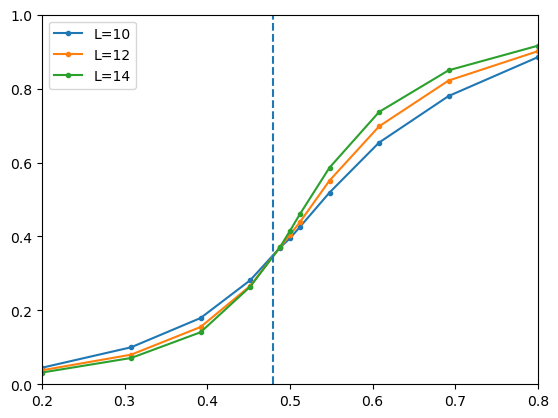

In [124]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed')
# ax.axhline(y=0.5)
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

(0.0, 1.0)

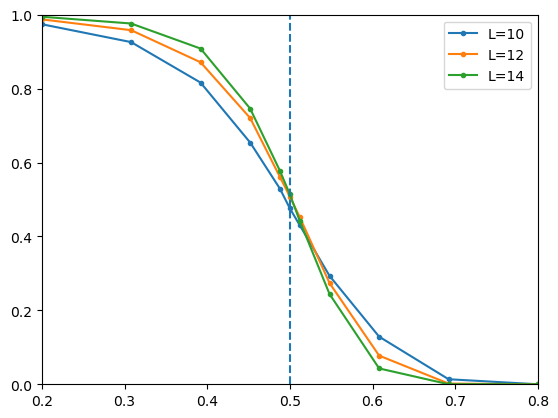

In [125]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.5,ls='dashed')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

(0.0, 1.0)

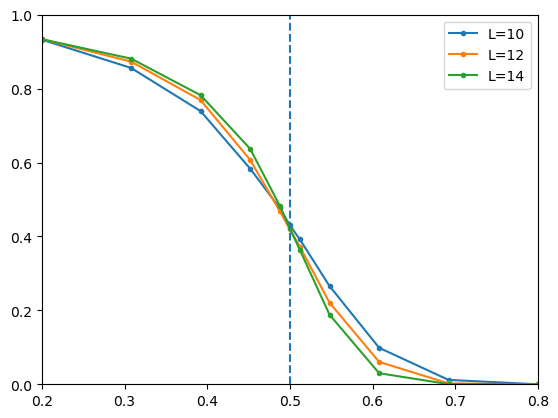

In [ ]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.5,ls='dashed')
ax.set_xlim([.2,.8])
ax.set_ylim([0,1])

(0.2, 0.8)

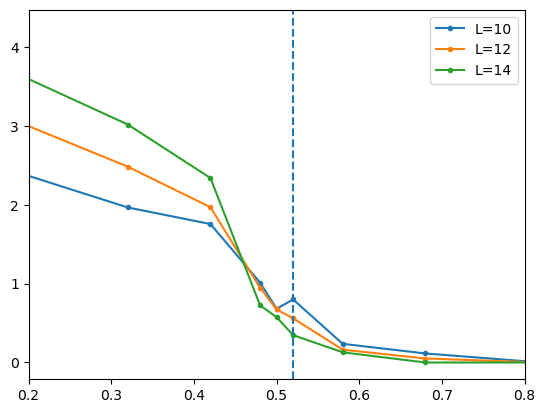

In [39]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed')
ax.set_xlim([.2,.8])

(0.2, 0.8)

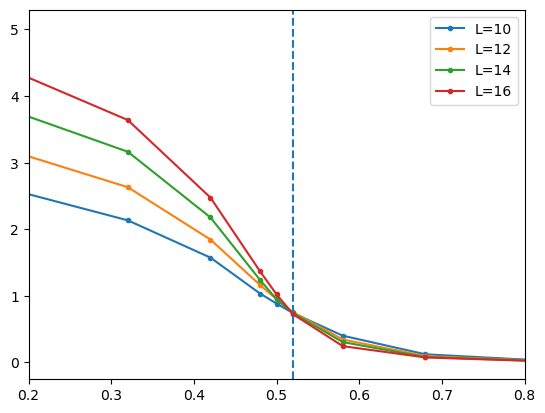

In [ ]:
fig,ax=plt.subplots()
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.52,ls='dashed')
ax.set_xlim([.2,.8])

## sweep p_proj, sweep p_ctrol for different L

In [29]:
rs=np.array(list(results)).reshape((L_list.shape[0],p_ctrl_list.shape[0],p_proj_list.shape[0],ensemble,2))

In [30]:
O_map,EE_map=rs[:,:,:,:,0],rs[:,:,:,:,1]

Text(0.5, 1.0, '$p_{proj}=0.000$')

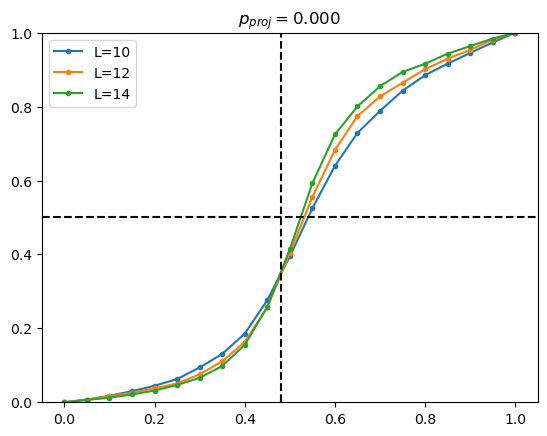

In [75]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

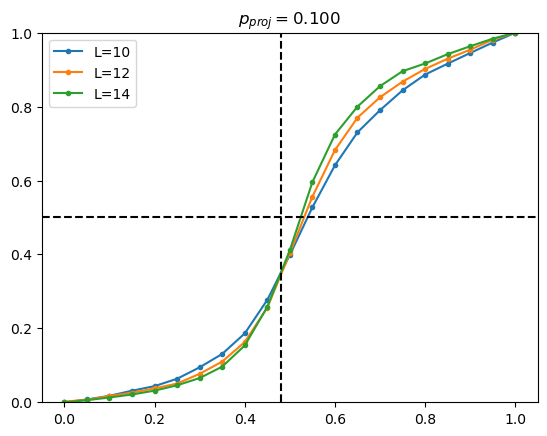

In [76]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

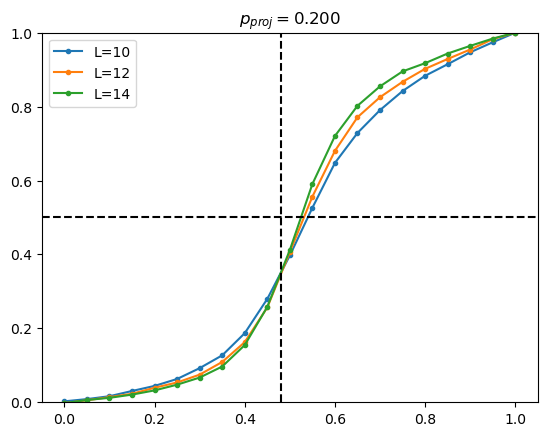

In [77]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

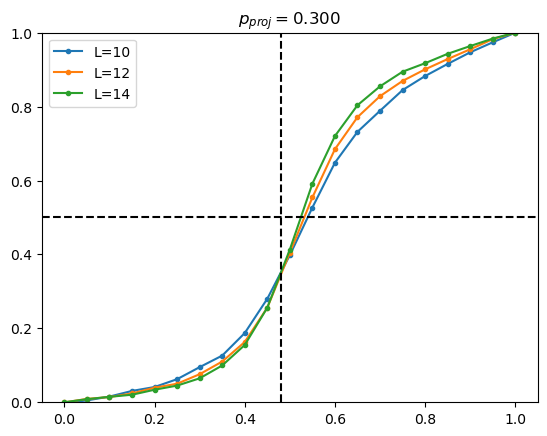

In [78]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

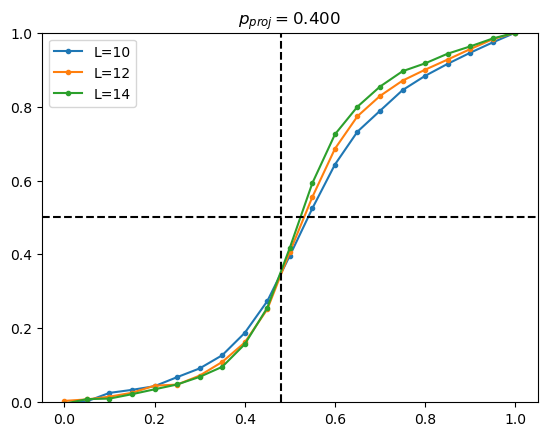

In [79]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

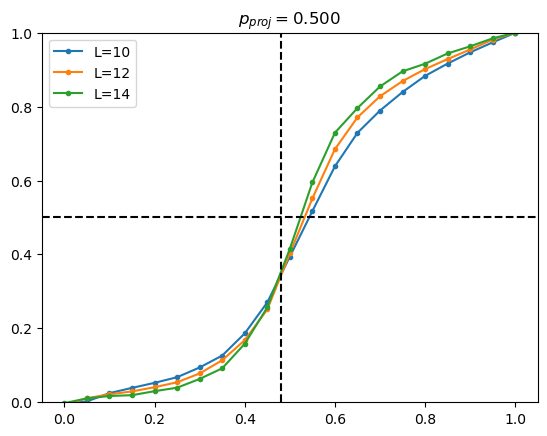

In [81]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(O_map.shape[0]):
    ax.plot(p_ctrl_list,O_map[i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.000$')

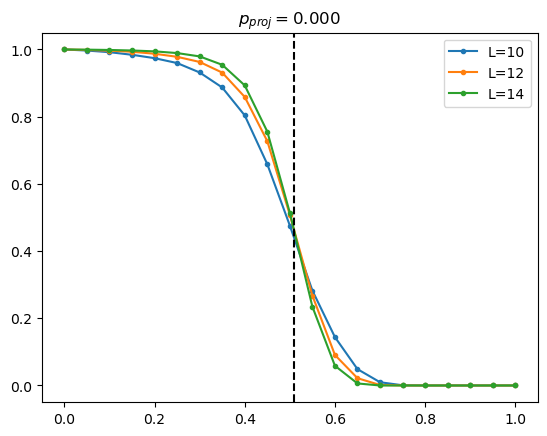

In [83]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

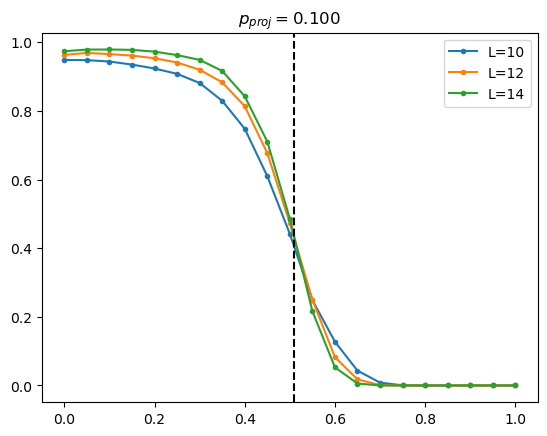

In [84]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

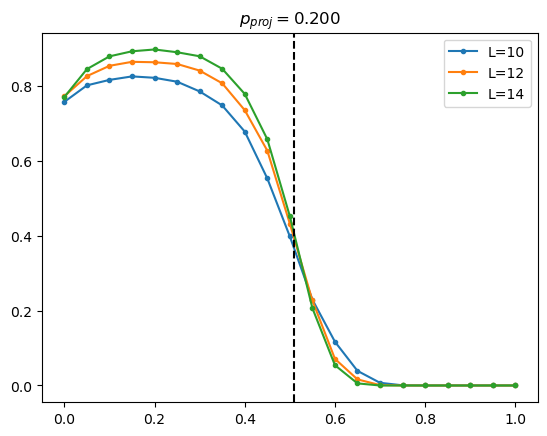

In [86]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

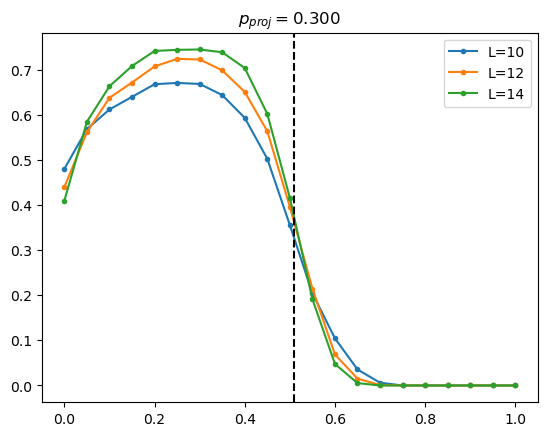

In [87]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

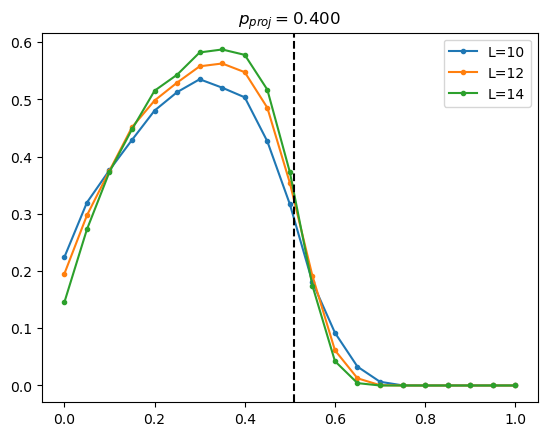

In [88]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

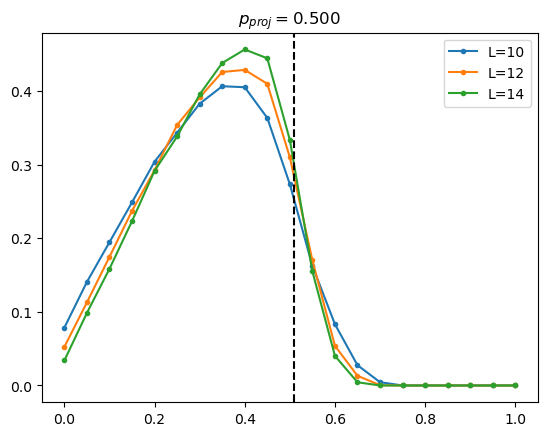

In [89]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

### S_L/2

Text(0.5, 1.0, '$p_{proj}=0.000$')

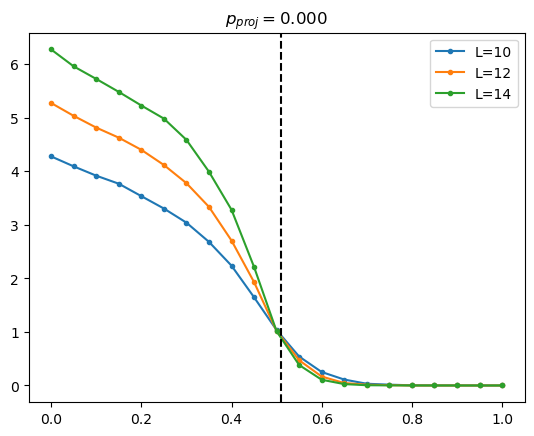

In [36]:
fig,ax=plt.subplots()
p_proj_idx=0
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.100$')

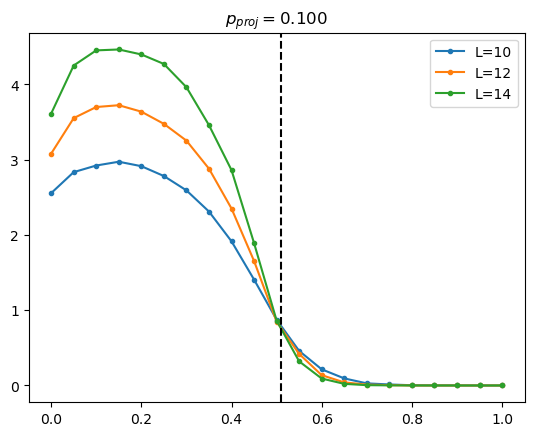

In [35]:
fig,ax=plt.subplots()
p_proj_idx=1
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.200$')

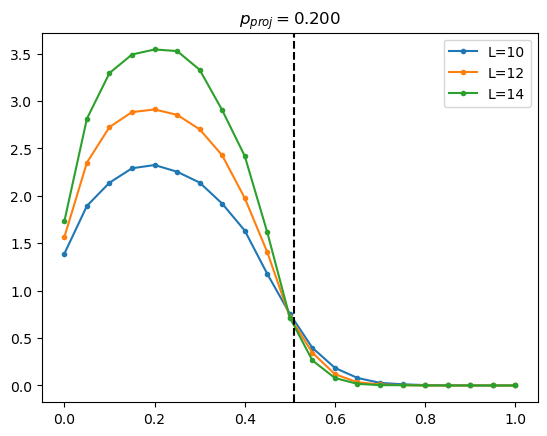

In [37]:
fig,ax=plt.subplots()
p_proj_idx=2
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.300$')

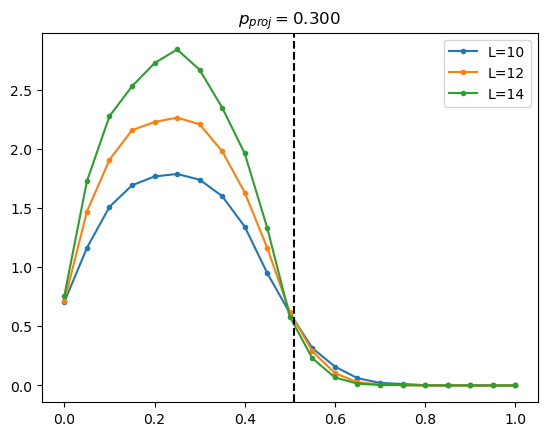

In [38]:
fig,ax=plt.subplots()
p_proj_idx=3
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.400$')

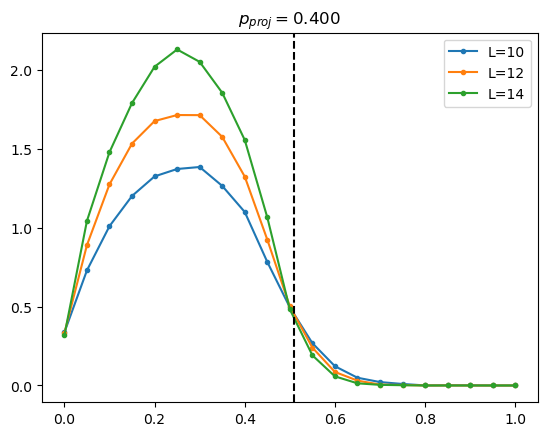

In [39]:
fig,ax=plt.subplots()
p_proj_idx=4
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

Text(0.5, 1.0, '$p_{proj}=0.500$')

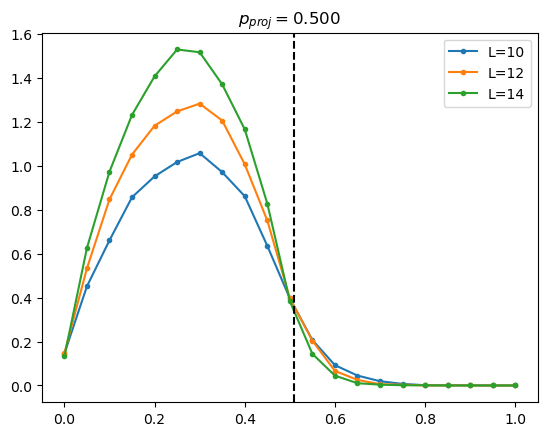

In [40]:
fig,ax=plt.subplots()
p_proj_idx=5
for i in range(EE_map.shape[0]):
    ax.plot(p_ctrl_list,EE_map[i,:,p_proj_idx].mean(axis=-1)/np.log(2),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.51,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')

In [91]:
p_ctrl_map,p_proj_map=np.meshgrid(p_ctrl_list,p_proj_list)

In [92]:
proj_map=(1-p_ctrl_map)*p_proj_map+p_ctrl_map

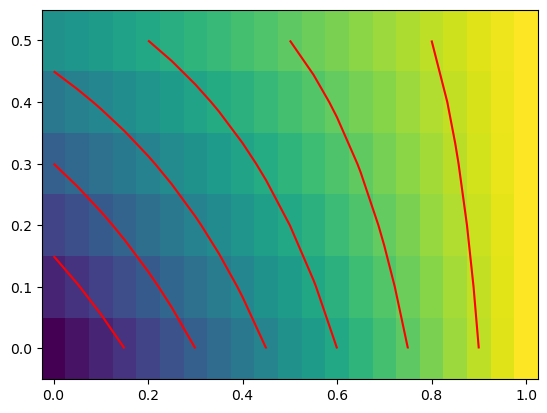

In [97]:
fig,ax=plt.subplots()
ax.pcolormesh(p_ctrl_list,p_proj_list,proj_map,shading='auto')
ax.contour(p_ctrl_list,p_proj_list,proj_map,colors='r')

## Everything fixed to check thermalization time

In [99]:
SA=np.array(list(results))

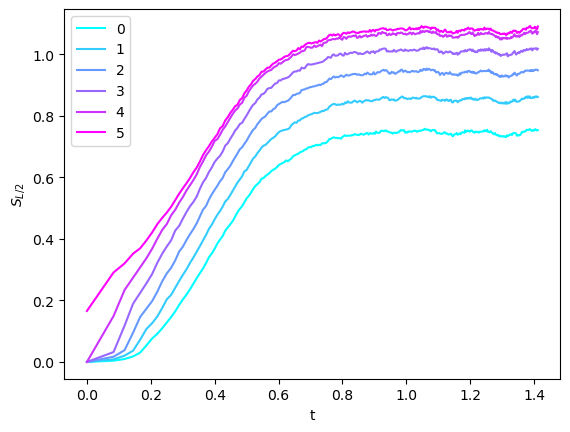

In [101]:
fig,ax=plt.subplots()
L=12
t_list=np.arange(2*L**2)
t_list=np.sqrt(t_list/L**2)

cmap = plt.get_cmap('cool')
cmap_discretized=[cmap(i) for i in np.linspace(0, 1, L//2)]
for idx in range(L//2):
    ax.plot(t_list,SA.mean(axis=0)[:,idx],label=f'{idx}',color=cmap_discretized[idx])
ax.set_ylabel('$S_{L/2}$')
ax.set_xlabel('t')
ax.legend()

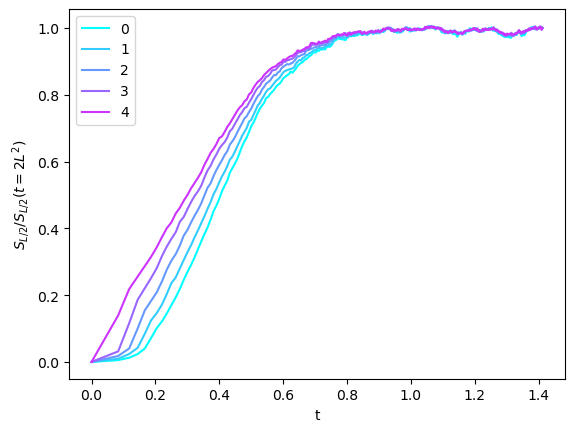

In [103]:
fig,ax=plt.subplots()
for idx in range(5):
    ax.plot(t_list,SA.mean(axis=0)[:,idx]/SA.mean(axis=0)[-1,idx],label=f'{idx}',color=cmap_discretized[idx])

ax.set_ylabel('$S_{L/2}/S_{L/2}(t=2L^2)$')
ax.set_xlabel('t')
ax.legend()
# ax.set_yscale('log')
# ax.set_ylim([0,1])
# ax.set_xlim([70,90])

In [ ]:
rs=np.array(list(results)).reshape((L_list.shape[0],ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]

In [ ]:
rs=np.array(list(results)).reshape((ensemble,2))
O_map,EE_map=rs[:,:,0],rs[:,:,1]